<a href="https://colab.research.google.com/github/francescovenco000004/VAE-collection/blob/main/1_beta_VAE_fcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading data


In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
# Change to the project directory
project_path = "/content/drive/My Drive/beta-VAE/.1_prisonersdilema_nonsequential"
os.chdir(project_path)

# Verify the current working directory
print("Current Working Directory: ", os.getcwd())
import sys

sys.path.append(project_path)

# Verify that the project path is in the Python path
print("Python Path: ", sys.path)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-1-b5520df14349>", line 3, in <cell line: 3>
    drive.mount('/content/drive')
  File "/usr/local/lib/python3.10/dist-packages/google/colab/drive.py", line 100, in mount
    return _mount(
  File "/usr/local/lib/python3.10/dist-packages/google/colab/drive.py", line 257, in _mount
    case = d.expect([
  File "/usr/local/lib/python3.10/dist-packages/pexpect/spawnbase.py", line 354, in expect
    return self.expect_list(compiled_pattern_list,
  File "/usr/local/lib/python3.10/dist-packages/pexpect/spawnbase.py", line 383, in expect_list
    return exp.expect_loop(timeout)
  File "/usr/local/lib/python3.10/dist-packages/pexpect/expect.py", line 171, in expect_loop
    time.sleep(self.spawn.delayafterread)
KeyboardInterrupt

During handling of the above exception, another exce

TypeError: object of type 'NoneType' has no len()

In [ ]:
import pandas as pd

df = pd.DataFrame(pd.read_csv("clean.1 - Sheet1.csv"))
df = df.drop('Unnamed: 21', axis=1)
df.head()


,T,R,P,S,risk,tempt,eff,l,g,Kindex,...,belief,B_is_Coop,BeliefThenChoice,switcher,age,female,nationality,ethnicity,education,econmajor
0,600,500,200,20,0.90,0.166667,0.6,0.600000,0.333333,0.517241,...,0.81,1,0,1,29,0,0,1,3,-1
1,600,500,400,180,0.55,0.166667,0.2,2.200000,1.000000,0.238095,...,0.35,0,1,1,29,0,0,1,3,-1
2,600,500,200,90,0.55,0.166667,0.6,0.366667,0.333333,0.588235,...,0.42,0,0,1,29,0,0,1,3,-1
3,800,500,400,40,0.90,0.375000,0.2,3.600000,3.000000,0.131579,...,0.58,1,0,1,29,0,0,1,3,-1
4,800,500,400,180,0.55,0.375000,0.2,2.200000,3.000000,0.161290,...,0.57,0,1,1,29,0,0,1,3,-1


In [ ]:
print(df.shape)


(2240, 21)


In [ ]:
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd

# Assume df has been pre-processed and loaded
df = pd.DataFrame(pd.read_csv("clean.1 - Sheet1.csv"))
df = df.drop('Unnamed: 21', axis=1)

# Split features (X) and labels (if available, or use X for unsupervised learning)
# In this case, assuming all columns are features for VAE, except for any unwanted columns
X = df.values  # Convert the DataFrame to NumPy array

# Convert the NumPy array to PyTorch tensor
X_tensor = torch.tensor(X, dtype=torch.float32)

# Optionally split the data into train and validation sets
X_train, X_val = train_test_split(X_tensor, test_size=0.2, random_state=42)

# Create PyTorch Dataset and DataLoader
train_dataset = TensorDataset(X_train)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, pin_memory=True)


FileNotFoundError: [Errno 2] No such file or directory: 'clean.1 - Sheet1.csv'

# dependencies


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


# Encoder and Decoder

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, z_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc_mu = nn.Linear(hidden_dim2, z_dim)
        self.fc_logvar = nn.Linear(hidden_dim2, z_dim)

    def forward(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        mu = self.fc_mu(h2)
        logvar = self.fc_logvar(h2)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim1, hidden_dim2, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(z_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, output_dim)  # Add an additional layer for more complexity

    def forward(self, z):
        h = F.relu(self.fc1(z))
        h = F.relu(self.fc2(h))
        x_recon = self.fc3(h)  # Raw logits output
        return x_recon



# Beta VAE

In [ ]:
class BetaVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, z_dim, beta=1.0):
        super(BetaVAE, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim1, hidden_dim2, z_dim)
        self.decoder = Decoder(z_dim, hidden_dim2, hidden_dim1, input_dim)
        self.beta = beta

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)   # Convert log variance to standard deviation
        eps = torch.randn_like(std)     # Sample epsilon from N(0, 1)
        return mu + eps * std           # Reparameterization trick

    def forward(self, x):
        mu, logvar = self.encoder(x)    # Encode input into mu and logvar
        z = self.reparameterize(mu, logvar)  # Sample z using reparameterization
        x_recon = self.decoder(z)       # Reconstruct the input from latent z
        return x_recon, mu, logvar      # Return reconstruction, mu, and logvar

    def loss_function(self, x, x_recon, mu, logvar):
        # Using binary cross entropy with logits and mean reduction
        recon_loss = F.binary_cross_entropy_with_logits(x_recon, x, reduction='mean')

        # KL Divergence loss
        kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        # Return combined loss with beta scaling KL divergence
        return recon_loss + self.beta * kl_div


# Training loop


In [ ]:
import torch
from torch import amp
from torch.cuda.amp import GradScaler  # For mixed precision training
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Device handling for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load and preprocess your data
df = pd.read_csv("clean.1 - Sheet1.csv")
df = df.drop('Unnamed: 21', axis=1)

# Convert DataFrame to NumPy array and then to a PyTorch tensor
X = df.values  # Using all columns as features for unsupervised VAE
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Normalize your features
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)

# Split the data into training and validation sets (optional)
X_train, X_val = train_test_split(X_tensor, test_size=0.2, random_state=42)

# Create PyTorch Dataset and DataLoader
train_dataset = TensorDataset(X_train)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, pin_memory=True)

# Hyperparameters for the VAE
input_dim = 21  # 21 input features in the dataset
hidden_dim1 = 64
hidden_dim2 = 32
z_dim = 8
beta = 4.0  # Beta for disentanglement

# Initialize model, optimizer, and scaler for mixed precision
model = BetaVAE(input_dim=input_dim, hidden_dim1=hidden_dim1, hidden_dim2=hidden_dim2, z_dim=z_dim, beta=beta).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scaler = GradScaler()  # Mixed precision gradient scaler

# Training loop
model.train()
num_epochs = 10
save_path = './vae_model.pth'  # Path to save the model

for epoch in range(num_epochs):  # Set the number of epochs
    train_loss = 0
    for batch_idx, (data,) in enumerate(train_loader):  # The tuple (data,) is used as there's no label
        data = data.to(device).float()

        # Forward pass with mixed precision
        optimizer.zero_grad()
        with amp.autocast(device_type='cuda'):  # Specify device type for mixed precision context
            x_recon, mu, logvar = model(data)
            # Debugging outputs
            print(f"x_recon: {x_recon}, mu: {mu}, logvar: {logvar}")  # Check for nan values
            loss = model.loss_function(data, x_recon, mu, logvar)

        # Backpropagation and optimization with scaled gradients
        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Clip gradients
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()

    # Print the average loss per epoch
    avg_loss = train_loss / len(train_loader.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

    # Save the model after each epoch
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': avg_loss,
    }, save_path)
    print(f"Model saved after epoch {epoch+1} at {save_path}")




<ipython-input-23-81fb16bed00a>:40: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # Mixed precision gradient scaler


x_recon: tensor([[ 0.2800,  0.0470,  0.0327,  ..., -0.0628, -0.0041,  0.1224],
        [ 0.3057,  0.0911,  0.1158,  ..., -0.2488, -0.0979,  0.3101],
        [ 0.2246,  0.0244, -0.0905,  ..., -0.1069, -0.0972,  0.1340],
        ...,
        [ 0.2905, -0.0185, -0.0239,  ..., -0.0593, -0.0687,  0.0985],
        [ 0.2683,  0.0483,  0.1199,  ..., -0.0880,  0.0242,  0.0681],
        [ 0.2905,  0.0159, -0.0789,  ..., -0.2312, -0.2494,  0.2908]],
       device='cuda:0', dtype=torch.float16, grad_fn=<AddmmBackward0>), mu: tensor([[-0.0773, -0.1943, -0.1278,  ...,  0.1898,  0.0945, -0.1936],
        [ 0.0492, -0.1510, -0.0600,  ...,  0.2791, -0.0618, -0.2487],
        [-0.0150, -0.0794, -0.1328,  ...,  0.2249, -0.0443, -0.2319],
        ...,
        [-0.0243, -0.0906, -0.2012,  ...,  0.3271,  0.0874, -0.1998],
        [-0.0829,  0.0016, -0.1290,  ...,  0.1741, -0.0946, -0.1603],
        [-0.0587, -0.2161, -0.1620,  ...,  0.1779,  0.1992, -0.1637]],
       device='cuda:0', dtype=torch.float16, gr

# Load model

In [ ]:
import torch

# Step 1: Re-define your model architecture (BetaVAE should be defined)
input_dim = 21
hidden_dim1 = 64
hidden_dim2 = 32
z_dim = 8
beta = 4.0

# Create a model instance
model = BetaVAE(input_dim=input_dim, hidden_dim1=hidden_dim1, hidden_dim2=hidden_dim2, z_dim=z_dim, beta=beta)

# Step 2: Load the saved checkpoint, specifying that it should be loaded to the CPU
checkpoint = torch.load('vae_model.pth', map_location='cpu')

# Step 3: Load the model state dictionary
model.load_state_dict(checkpoint['model_state_dict'])

# Step 4: (Optional) If you want to load the optimizer state as well
# optimizer = optim.Adam(model.parameters(), lr=1e-3)  # Initialize optimizer
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Step 5: Set to evaluation mode for inference
model.eval()

print("Model loaded on CPU.")


<ipython-input-6-d630df0459f3>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('vae_model.pth', map_location='cpu')


Model loaded on CPU.


### using the model


In [ ]:
import torch

#set the model to evaluation mode
model.eval()

#prepare data
X_tensor = X_tensor.to('cpu')


# Move the model to CPU if it was trained on GPU
model = model.to('cpu')

# Assuming you want to encode all the data in X_tensor
with torch.no_grad():  # No need to track gradients during inference
    # Pass the data through the encoder to get `mu` and `logvar`
    _, mu, _ = model(X_tensor)

# `mu` is your latent space representation of the input data
latent_vectors = mu.numpy()  # Convert latent vectors to NumPy for easier EDA


In [ ]:
print(X_tensor.shape)
print(X_tensor[:5])

torch.Size([2240, 21])
tensor([[ 6.0000e+02,  5.0000e+02,  2.0000e+02,  2.0000e+01,  9.0000e-01,
          1.6667e-01,  6.0000e-01,  6.0000e-01,  3.3333e-01,  5.1724e-01,
          1.0000e+00,  8.1000e-01,  1.0000e+00,  0.0000e+00,  1.0000e+00,
          2.9000e+01,  0.0000e+00,  0.0000e+00,  1.0000e+00,  3.0000e+00,
         -1.0000e+00],
        [ 6.0000e+02,  5.0000e+02,  4.0000e+02,  1.8000e+02,  5.5000e-01,
          1.6667e-01,  2.0000e-01,  2.2000e+00,  1.0000e+00,  2.3810e-01,
          0.0000e+00,  3.5000e-01,  0.0000e+00,  1.0000e+00,  1.0000e+00,
          2.9000e+01,  0.0000e+00,  0.0000e+00,  1.0000e+00,  3.0000e+00,
         -1.0000e+00],
        [ 6.0000e+02,  5.0000e+02,  2.0000e+02,  9.0000e+01,  5.5000e-01,
          1.6667e-01,  6.0000e-01,  3.6667e-01,  3.3333e-01,  5.8824e-01,
          1.0000e+00,  4.2000e-01,  0.0000e+00,  0.0000e+00,  1.0000e+00,
          2.9000e+01,  0.0000e+00,  0.0000e+00,  1.0000e+00,  3.0000e+00,
         -1.0000e+00],
        [ 8.0000e+02

In [ ]:
print(latent_vectors.shape)
print(latent_vectors[0])
print(latent_vectors[1])
print(latent_vectors[2])
print(latent_vectors[3])

(2240, 8)
[  8.528023     4.7475305    8.094679     0.46873263   2.8688793
 -14.023681     7.7837276    8.386135  ]
[ 10.526784    5.0546403   6.2867856  -1.0516605   2.8737292 -19.472996
  12.883398   10.074835 ]
[  8.992425     5.060779     7.9310265    0.65482044   2.9581852
 -14.585245     8.228865     8.55234   ]
[ 10.684738     5.7291355    8.227627    -0.11039732   2.828905
 -19.381657    11.987916    10.611015  ]


In [ ]:
latent_vectors_df = pd.DataFrame(latent_vectors)

# Save to CSV
latent_vectors_df.to_csv('latent_vectors.csv', index=False)

print("Latent vectors saved as 'latent_vectors.csv'")

Latent vectors saved as 'latent_vectors.csv'


# PCA


Explained Variance Ratio: [0.62963145 0.25149537]
Principal Components Shape: (2240, 2)


<ipython-input-5-7985b695c6ad>:20: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(latent_vectors_pca[:, 0], latent_vectors_pca[:, 1], s=10, cmap='viridis')


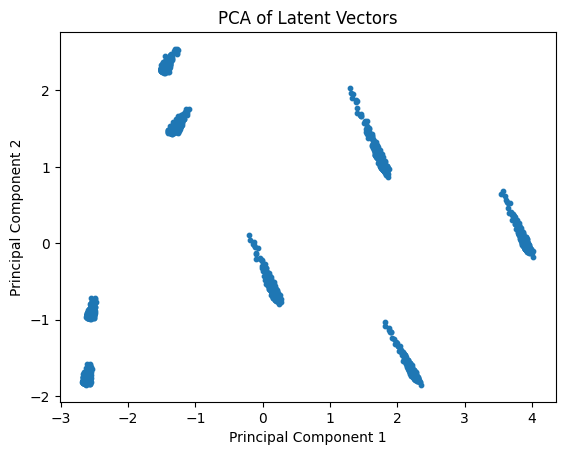

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt

latent_vectors = pd.read_csv('latent_vectors.csv').values

#standardise
scalar = StandardScaler()
latent_vectors_scaled = scalar.fit_transform(latent_vectors)

#peform PCA
pca = PCA(n_components=2)
latent_vectors_pca = pca.fit_transform(latent_vectors_scaled)

print("Explained Variance Ratio:", pca.explained_variance_ratio_)
print("Principal Components Shape:", latent_vectors_pca.shape)

#visualise
plt.scatter(latent_vectors_pca[:, 0], latent_vectors_pca[:, 1], s=10, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Latent Vectors')
plt.show()



Explained Variance Ratio: [0.62963145 0.25149537 0.09164912]
Principal Components Shape: (2240, 3)


<ipython-input-7-f78e2a8f976f>:24: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(latent_vectors_pca[:, 0], latent_vectors_pca[:, 1], latent_vectors_pca[:, 2], s=10, cmap='viridis')


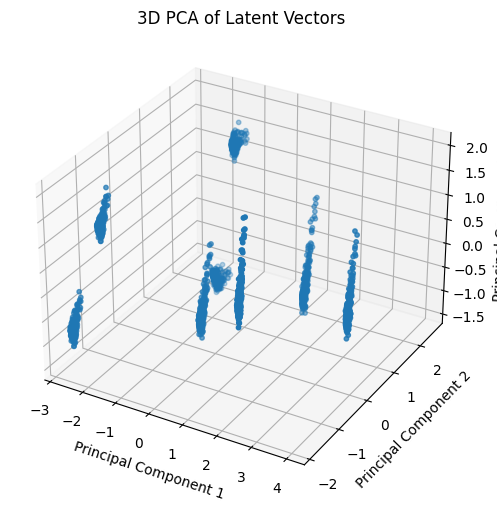

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

latent_vectors = pd.read_csv('latent_vectors.csv').values

#standardise
scalar = StandardScaler()
latent_vectors_scaled = scalar.fit_transform(latent_vectors)

#peform PCA
pca = PCA(n_components=3)
latent_vectors_pca = pca.fit_transform(latent_vectors_scaled)

print("Explained Variance Ratio:", pca.explained_variance_ratio_)
print("Principal Components Shape:", latent_vectors_pca.shape)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for 3 PCA components
ax.scatter(latent_vectors_pca[:, 0], latent_vectors_pca[:, 1], latent_vectors_pca[:, 2], s=10, cmap='viridis')

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.title('3D PCA of Latent Vectors')
plt.show()



# Correlation with known features


In [ ]:
import pandas as pd
import numpy as np

latent_vectors = pd.read_csv('latent_vectors.csv').values
original_data = pd.read_csv('clean.1 - Sheet1.csv').values


latent_df = pd.DataFrame(latent_vectors, columns=[f'latent_{i}' for i in range(latent_vectors.shape[1])])
original_df = pd.DataFrame(original_data, columns=[f'feature_{i}' for i in range(original_data.shape[1])])
original_df = original_df.drop(original_df.columns[21], axis=1)

print(latent_df.head())
print(original_df.head())
print(latent_df.shape)
print(original_df.shape)


    latent_0  latent_1  latent_2  latent_3  latent_4   latent_5   latent_6  \
0   8.528023  4.747530  8.094679  0.468733  2.868879 -14.023681   7.783728   
1  10.526784  5.054640  6.286786 -1.051661  2.873729 -19.472996  12.883398   
2   8.992425  5.060779  7.931026  0.654820  2.958185 -14.585245   8.228865   
3  10.684738  5.729135  8.227627 -0.110397  2.828905 -19.381657  11.987916   
4  12.012996  5.433159  6.825380 -0.896570  2.802397 -21.797146  14.388490   

    latent_7  
0   8.386135  
1  10.074835  
2   8.552340  
3  10.611015  
4  10.602005  
  feature_0 feature_1 feature_2 feature_3 feature_4 feature_5 feature_6  \
0       600       500       200        20       0.9  0.166667       0.6   
1       600       500       400       180      0.55  0.166667       0.2   
2       600       500       200        90      0.55  0.166667       0.6   
3       800       500       400        40       0.9     0.375       0.2   
4       800       500       400       180      0.55     0.375     

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

spearman_corr = latent_df.corrwith(original_df, axis=0, method='spearman')

# Visualizing Pearson correlation as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation between Latent Dimensions and Original Features')
plt.show()


<ipython-input-9-445aa5dc8a7c>:4: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  spearman_corr = latent_df.corrwith(original_df, axis=0, method='spearman')


IndexError: Inconsistent shape between the condition and the input (got (29, 1) and (29,))

<Figure size 1000x800 with 0 Axes>

/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]


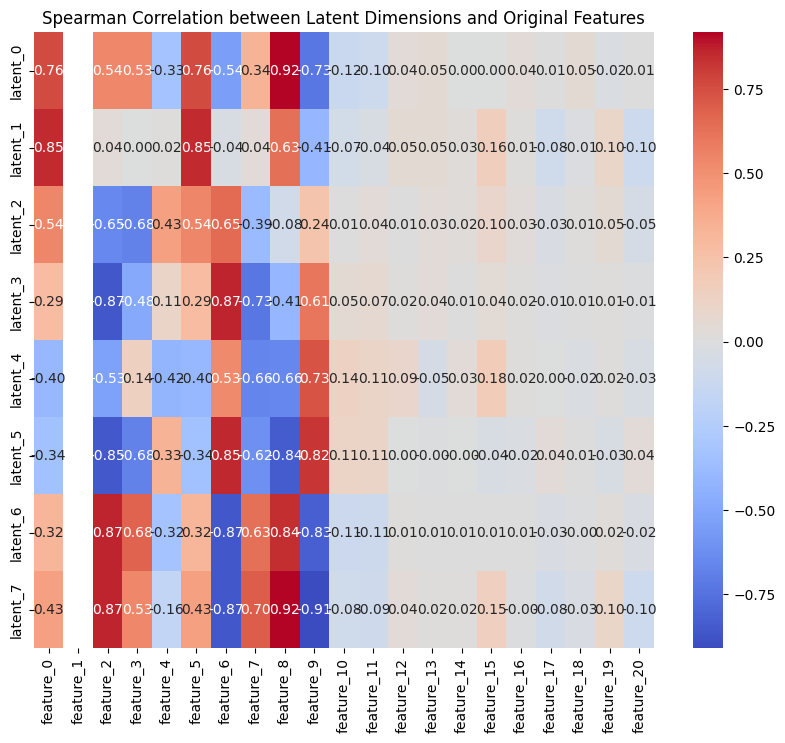

In [ ]:
# First ensure there are no missing values in either DataFrame
assert not latent_df.isnull().values.any(), "latent_df contains NaNs"
assert not original_df.isnull().values.any(), "original_df contains NaNs"

# Compute the Spearman correlation between latent dimensions and original features
spearman_corr = pd.DataFrame(index=latent_df.columns, columns=original_df.columns)

for latent_col in latent_df.columns:
    for original_col in original_df.columns:
        spearman_corr.loc[latent_col, original_col] = latent_df[latent_col].corr(original_df[original_col], method='spearman')

# Convert the DataFrame to numeric types (if needed)
spearman_corr = spearman_corr.astype(float)

# Plotting the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Spearman Correlation between Latent Dimensions and Original Features')
plt.show()
